In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

def create_listing_id_split_files(data_path, output_dir='.', test_size=0.2, random_state=42):
    """
    Create two text files containing listing IDs for train (80%) and test (20%) sets.
    
    Parameters:
    -----------
    data_path : str
        Path to the CSV file containing listing data with listing_id column
    output_dir : str
        Directory where train_ids.txt and test_ids.txt will be saved
    test_size : float
        Proportion of unique listings to be used as test set
    random_state : int
        Random seed for reproducibility
    """
    # Check if the file exists
    if not os.path.exists(data_path):
        print(f"Error: File {data_path} does not exist!")
        return
    
    # Read the data
    print(f"Reading data from {data_path}...")
    try:
        # First try reading with listing_id column
        df = pd.read_csv(data_path)
        id_column = 'listing_id' if 'listing_id' in df.columns else 'id'
        
        if id_column not in df.columns:
            print(f"Error: Neither 'listing_id' nor 'id' column found in the dataset!")
            return
    except:
        print(f"Error reading {data_path}. Please check the file format.")
        return
    
    # Get unique listing IDs
    unique_listings = df[id_column].unique()
    print(f"Found {len(unique_listings)} unique listings.")
    
    # Split the unique listing IDs into train and test sets
    print(f"Creating {int((1-test_size)*100)}-{int(test_size*100)} train-test split...")
    train_listings, test_listings = train_test_split(
        unique_listings, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save the train and test listing IDs to text files
    train_path = os.path.join(output_dir, 'train_ids.txt')
    test_path = os.path.join(output_dir, 'test_ids.txt')
    
    # Save train listing IDs
    print(f"Saving {len(train_listings)} training listing IDs to {train_path}...")
    with open(train_path, 'w') as f:
        for listing_id in train_listings:
            f.write(f"{listing_id}\n")
    
    # Save test listing IDs
    print(f"Saving {len(test_listings)} test listing IDs to {test_path}...")
    with open(test_path, 'w') as f:
        for listing_id in test_listings:
            f.write(f"{listing_id}\n")
    
    print("Done!")
    return train_listings, test_listings

# Example usage
if __name__ == "__main__":
    # You can use either calendar.csv or listings.csv to get unique listing IDs
    data_file = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\train.csv"  # Update with your specific path
    output_directory = "."  # Current directory
    
    train_listings, test_listings = create_listing_id_split_files(
        data_path=data_file,
        output_dir=output_directory,
        test_size=0.2,  # 80-20 split
        random_state=42  # For reproducibility
    )
    
    # Print summary statistics
    print(f"\nSummary:")
    print(f"Training set: {len(train_listings)} unique listings ({len(train_listings) / (len(train_listings) + len(test_listings)) * 100:.1f}%)")
    print(f"Test set: {len(test_listings)} unique listings ({len(test_listings) / (len(train_listings) + len(test_listings)) * 100:.1f}%)")

Reading data from C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\train.csv...
Found 7864 unique listings.
Creating 80-20 train-test split...
Saving 6291 training listing IDs to .\train_ids.txt...
Saving 1573 test listing IDs to .\test_ids.txt...
Done!

Summary:
Training set: 6291 unique listings (80.0%)
Test set: 1573 unique listings (20.0%)


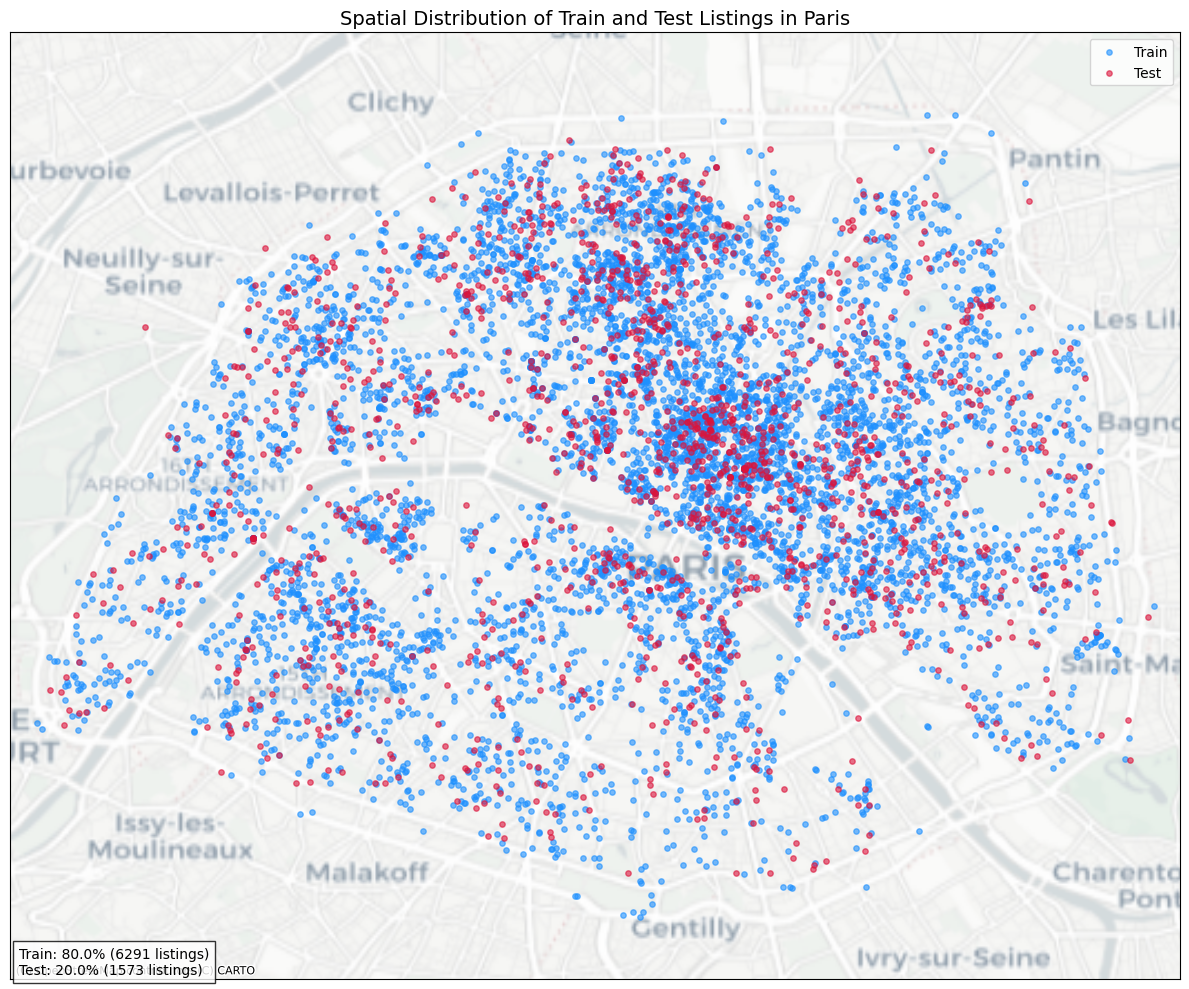

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap
import numpy as np

# Load the main dataset
# Update this path to your actual path to train.csv
train_df = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train.csv')

# Load the train and test IDs from your existing txt files
# Update these paths to your actual train_ids.txt and test_ids.txt files
train_ids = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt', header=None)[0].tolist()
test_ids = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt', header=None)[0].tolist()

# Extract unique listing coordinates
# Group by listing_id and take the first entry for each to get coordinates
listings_coords = train_df[['listing_id', 'latitude', 'longitude']].drop_duplicates('listing_id')

# Create a new column indicating if the listing is in train or test set
listings_coords['set'] = listings_coords['listing_id'].apply(
    lambda x: 'Train' if x in train_ids else 'Test' if x in test_ids else 'Unknown')

# Filter out any unknown listings (those not in either train or test sets)
listings_coords = listings_coords[listings_coords['set'] != 'Unknown']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Custom colormap with transparent colors
train_color = np.array([30/255, 144/255, 255/255, 0.6])  # Dodger blue with transparency
test_color = np.array([220/255, 20/255, 60/255, 0.6])    # Crimson with transparency
cmap = ListedColormap([train_color, test_color])

# Plot training data points 
train_data = listings_coords[listings_coords['set'] == 'Train']
ax.scatter(train_data['longitude'], train_data['latitude'], 
          color=train_color, s=15, label='Train')

# Plot test data points
test_data = listings_coords[listings_coords['set'] == 'Test']
ax.scatter(test_data['longitude'], test_data['latitude'], 
          color=test_color, s=15, label='Test')

# Add a background map of Paris
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

# Set the extent to focus on Paris 
# These coordinates approximately cover the Paris area
ax.set_xlim([2.25, 2.42])
ax.set_ylim([48.81, 48.91])

# Remove axis ticks and labels since we have a map background
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Add title and legend
plt.title('Spatial Distribution of Train and Test Listings in Paris', fontsize=14)
leg = plt.legend(loc='upper right', frameon=True)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.8)

# Add a note about the data
percentage_train = len(train_data) / len(listings_coords) * 100
percentage_test = len(test_data) / len(listings_coords) * 100
info_text = f'Train: {percentage_train:.1f}% ({len(train_data)} listings)\nTest: {percentage_test:.1f}% ({len(test_data)} listings)'
plt.figtext(0.02, 0.02, info_text, bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Save the figure
# plt.savefig('paris_map_train_test_distribution.png', dpi=300, bbox_inches='tight')

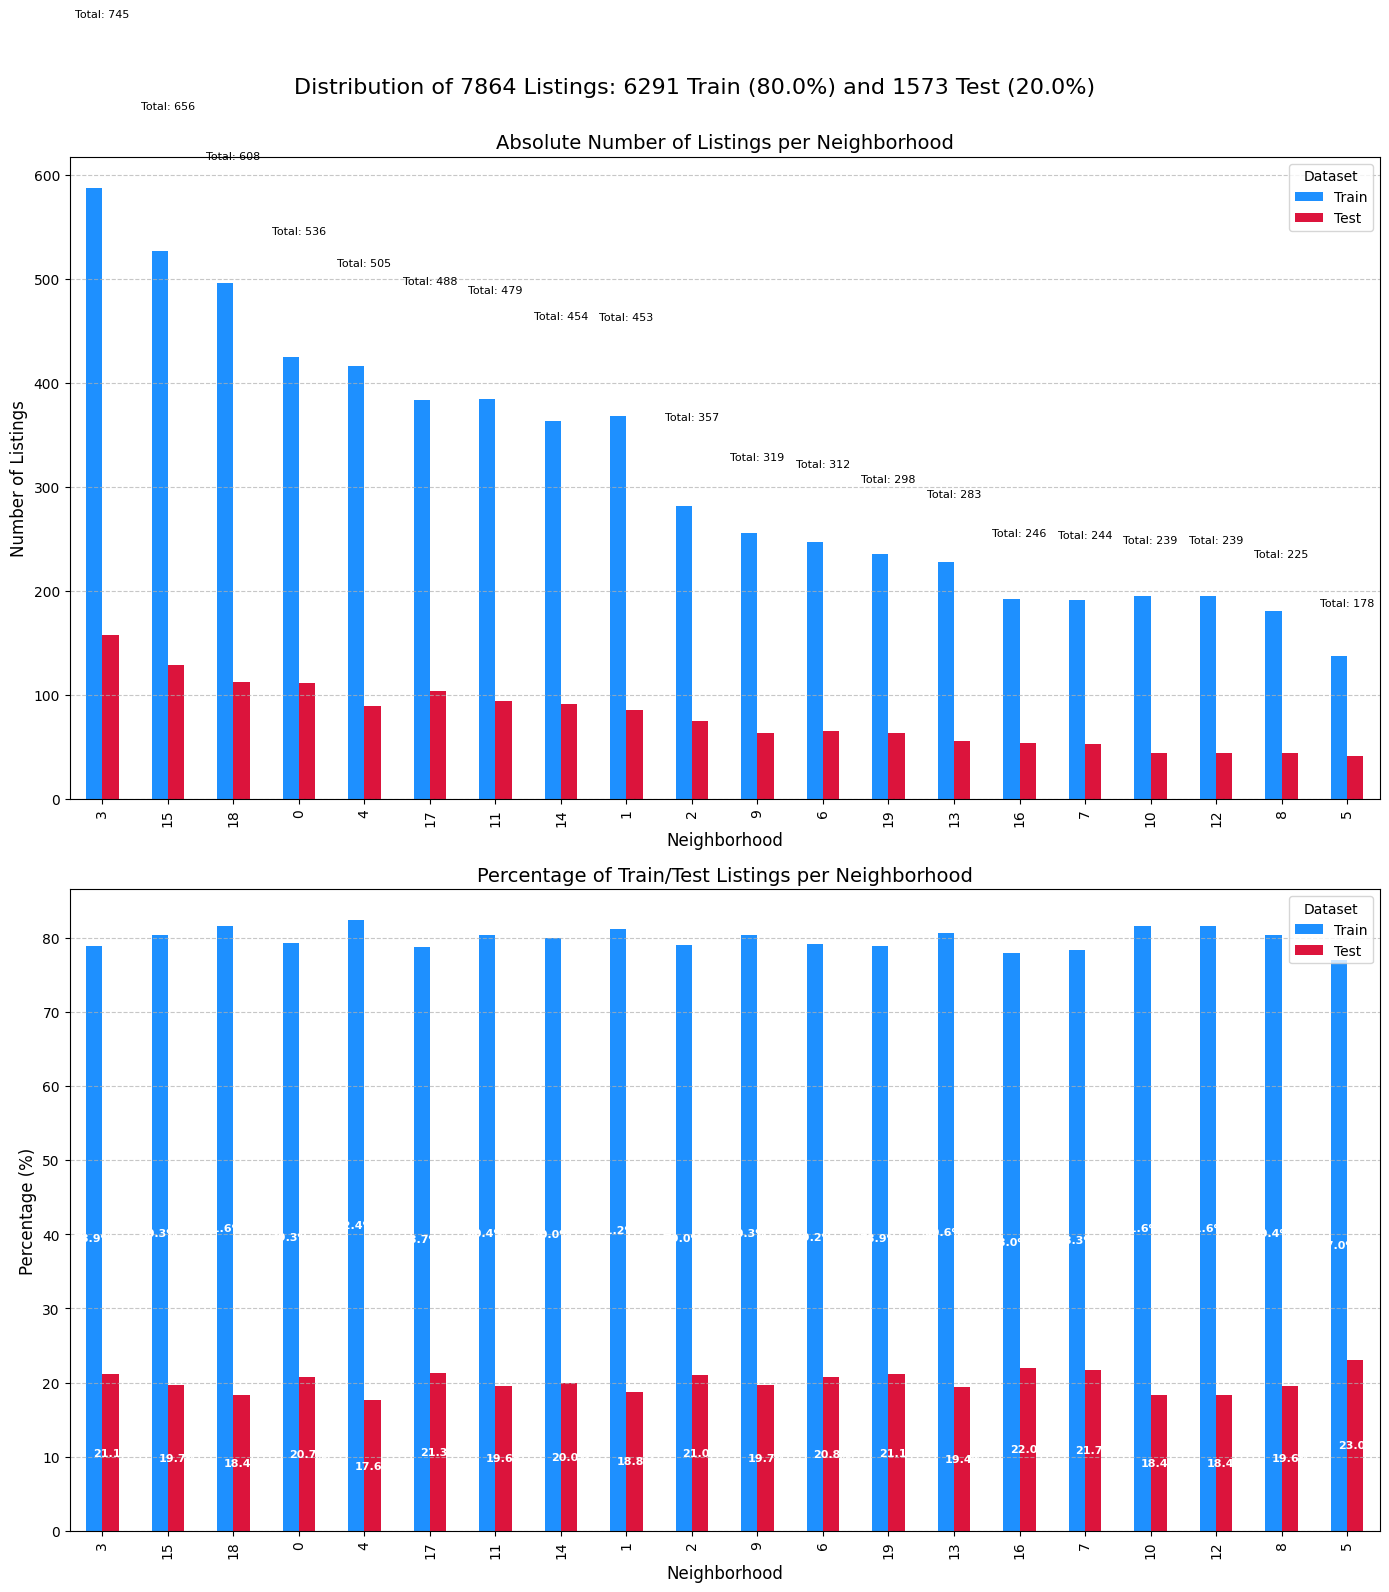


Neighborhood Distribution Summary:
 Neighborhood  Train Count  Test Count  Total Count  Train %  Test %
            3          588         157          745     78.9    21.1
           15          527         129          656     80.3    19.7
           18          496         112          608     81.6    18.4
            0          425         111          536     79.3    20.7
            4          416          89          505     82.4    17.6
           17          384         104          488     78.7    21.3
           11          385          94          479     80.4    19.6
           14          363          91          454     80.0    20.0
            1          368          85          453     81.2    18.8
            2          282          75          357     79.0    21.0
            9          256          63          319     80.3    19.7
            6          247          65          312     79.2    20.8
           19          235          63          298     78.9    21.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get a unique listing dataframe with neighborhood information
# Note: We need to retrieve the neighborhood information, not just the encoded value
# If 'neighbourhood_cleansed' is in your dataset, use that instead of 'neighbourhood_cleansed_encoded'
listings_info = train_df[['listing_id', 'neighbourhood_cleansed_encoded']].drop_duplicates('listing_id')
# Rename column for clarity
listings_info.rename(columns={'neighbourhood_cleansed_encoded': 'neighborhood'}, inplace=True)

# Create a new column indicating if the listing is in train or test set
listings_info['set'] = listings_info['listing_id'].apply(
    lambda x: 'Train' if x in train_ids else 'Test' if x in test_ids else 'Unknown')

# Filter out any unknown listings (those not in either train or test sets)
listings_info = listings_info[listings_info['set'] != 'Unknown']

# Count listings by neighborhood and set
neighborhood_counts = listings_info.groupby(['neighborhood', 'set']).size().unstack(fill_value=0)

# If any set is missing from the columns, add it with zeros
for col in ['Train', 'Test']:
    if col not in neighborhood_counts.columns:
        neighborhood_counts[col] = 0

# Calculate the total for each neighborhood
neighborhood_counts['Total'] = neighborhood_counts['Train'] + neighborhood_counts['Test']

# Calculate the percentage of train and test listings in each neighborhood
neighborhood_percentages = neighborhood_counts.copy()
neighborhood_percentages['Train'] = (neighborhood_counts['Train'] / neighborhood_counts['Total'] * 100).round(1)
neighborhood_percentages['Test'] = (neighborhood_counts['Test'] / neighborhood_counts['Total'] * 100).round(1)

# Sort by total listings (descending)
neighborhood_counts = neighborhood_counts.sort_values('Total', ascending=False)
neighborhood_percentages = neighborhood_percentages.loc[neighborhood_counts.index]

# Create a figure with two subplots: one for absolute counts and one for percentages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot absolute counts
neighborhood_counts[['Train', 'Test']].plot(kind='bar', stacked=False, ax=ax1, 
                                           color=['#1E90FF', '#DC143C'])
ax1.set_title('Absolute Number of Listings per Neighborhood', fontsize=14)
ax1.set_xlabel('Neighborhood', fontsize=12)
ax1.set_ylabel('Number of Listings', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(title='Dataset')

# Add total counts as text on top of each bar
for i, neighborhood in enumerate(neighborhood_counts.index):
    ax1.text(i, neighborhood_counts.loc[neighborhood, 'Total'] + 5, 
             f"Total: {neighborhood_counts.loc[neighborhood, 'Total']}", 
             ha='center', va='bottom', fontsize=8, rotation=0)

# Plot percentages
neighborhood_percentages[['Train', 'Test']].plot(kind='bar', stacked=False, ax=ax2, 
                                                color=['#1E90FF', '#DC143C'])
ax2.set_title('Percentage of Train/Test Listings per Neighborhood', fontsize=14)
ax2.set_xlabel('Neighborhood', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(title='Dataset')

# Add percentage labels on the percentage bars
for i, neighborhood in enumerate(neighborhood_percentages.index):
    # For train bars
    ax2.text(i-0.15, neighborhood_percentages.loc[neighborhood, 'Train']/2, 
             f"{neighborhood_percentages.loc[neighborhood, 'Train']}%", 
             ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    # For test bars
    ax2.text(i+0.15, neighborhood_percentages.loc[neighborhood, 'Test']/2, 
             f"{neighborhood_percentages.loc[neighborhood, 'Test']}%", 
             ha='center', va='center', fontsize=8, color='white', fontweight='bold')

# Display the total number of listings at the top of the figure
total_listings = neighborhood_counts['Total'].sum()
total_train = neighborhood_counts['Train'].sum()
total_test = neighborhood_counts['Test'].sum()
fig.suptitle(f'Distribution of {total_listings} Listings: {total_train} Train ({total_train/total_listings*100:.1f}%) and {total_test} Test ({total_test/total_listings*100:.1f}%)', 
             fontsize=16, y=0.95)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show plot
plt.show()

# Optional: Create a table with the data
result_table = pd.DataFrame({
    'Neighborhood': neighborhood_counts.index,
    'Train Count': neighborhood_counts['Train'],
    'Test Count': neighborhood_counts['Test'],
    'Total Count': neighborhood_counts['Total'],
    'Train %': neighborhood_percentages['Train'],
    'Test %': neighborhood_percentages['Test']
})

# Print the table
print("\nNeighborhood Distribution Summary:")
print(result_table.to_string(index=False))

# Optional: Save the table to CSV
# result_table.to_csv('neighborhood_distribution.csv', index=False)

# Optional: Save the figure
# plt.savefig('neighborhood_distribution.png', dpi=300, bbox_inches='tight')